# Gun Violence Capstone Project

# Machine Learning

The goal of this notebook is to create a supervised machine learning algorithm that can predict the number of people killed/injured as a result of gun violence based on a number of feature variables.

**0. Begin by importing relevant packages and data wrangling code.**

In [1]:
# Packages
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [3]:
df = pd.read_csv('Downloads/Data/gun-violence-data_01-2013_03-2018.csv', parse_dates=['date'])
df.drop(['incident_id','incident_url','source_url','incident_url_fields_missing','location_description','notes','participant_name','participant_relationship', 'sources', 'participant_status', 'address', 'latitude', 'longitude','participant_type','participant_age', 'gun_stolen', 'n_guns_involved'], axis = 1, inplace = True)
df.dropna(how = 'any', subset = ['incident_characteristics', 'state_house_district', 'congressional_district', 'state_senate_district'], inplace = True)
df['participant_age_group'].fillna('0::Unknown', inplace = True)
def agegroup_cleanup(row):
    agegroup_row_values = []
    agegroup_row = str(row).split("||")
    for x in agegroup_row :
        agegroup_row_value = str(x).split("::")
        if len(agegroup_row_value) > 1 :
            agegroup_row_values.append(agegroup_row_value[1])
    return agegroup_row_values
agegroupvalues = df.participant_age_group.apply(agegroup_cleanup)
df["agegroup_child"] = agegroupvalues.apply(lambda x: x.count("Child 0-11"))
df["agegroup_teen"] = agegroupvalues.apply(lambda x: x.count("Teen 12-17"))
df["agegroup_adult"] = agegroupvalues.apply(lambda x: x.count("Adult 18+"))
df = df[df['incident_characteristics'].str.contains('Non-Shooting Incident') == False]
df['date'] = pd.to_datetime(df.date)
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['monthday'] = df.date.dt.day
df['weekday'] = df.date.dt.weekday
city_list = df['city_or_county'].value_counts().head(15).index.tolist()
df = df[df['city_or_county'].apply(lambda x: x in city_list)]
df['participant_gender'].fillna('0::Unknown', inplace = True)
def gender_cleanup(row):
    gender_row_values = []
    gender_row = str(row).split("||")
    for x in gender_row :
        gender_row_value = str(x).split("::")
        if len(gender_row_value) > 1 :
            gender_row_values.append(gender_row_value[1])   
    return gender_row_values
participant_genders = df.participant_gender.apply(gender_cleanup)
df["participant_gender_total"] = participant_genders.apply(lambda x: len(x))
df["participant_gender_male"] = participant_genders.apply(lambda x: x.count("Male"))
df["participant_gender_female"] = participant_genders.apply(lambda x: x.count("Female"))
df["participant_gender_unknown"] = participant_genders.apply(lambda x: x.count("Unknown"))
big_text = "||".join(df['incident_characteristics']).split("||")
df['gun_type'].fillna('0::Unknown', inplace = True)
gt = df.groupby(by=['gun_type']).agg({'n_killed': 'sum', 'n_injured' : 'sum', 'state' : 'count'}).reset_index().rename(columns={'state':'count'})
results = {}
for i, each in gt.iterrows():
    wrds = each['gun_type'].split("||")
    for wrd in wrds:
        if "Unknown" in wrd:
            continue
        wrd = wrd.replace("::",":").replace("|1","")
        gtype = wrd.split(":")[1]
        if gtype not in results: 
            results[gtype] = {'killed' : 0, 'injured' : 0, 'used' : 0}
        results[gtype]['killed'] += each['n_killed']
        results[gtype]['injured'] +=  each['n_injured']
        results[gtype]['used'] +=  each['count']
gun_names = list(results.keys())
used = [each['used'] for each in list(results.values())]
killed = [each['killed'] for each in list(results.values())]
injured = [each['injured'] for each in list(results.values())]
incident_dict = {}
incident_dict2 = {}
for i, x in df['incident_characteristics'].iteritems():
    x = x.split('|')
    incident_dict[i] = x[0]
    if len(x)>1:
        if x[1] == '':
            incident_dict2[i] = x[2]
        else:
            incident_dict2[i] = x[1]
df2 = pd.DataFrame([incident_dict, incident_dict2])
df2 = df2.transpose()
df = pd.concat([df, df2], axis = 'columns')
df.rename(columns={0:'primary_characteristic', 1: 'secondary_characteristic'}, inplace=True)
df['city_or_county'] = pd.Categorical(df.city_or_county)
df['mapped_cities'] = df.city_or_county.cat.codes
df['primary_characteristic'] = pd.Categorical(df.primary_characteristic)
df['mapped_primary'] = df.primary_characteristic.cat.codes
df['secondary_characteristic'] = pd.Categorical(df.secondary_characteristic)
df['mapped_secondary'] = df.secondary_characteristic.cat.codes

**1. Select the feature and response variables**

In [4]:
# Select feature variables
X = df[['n_injured', 
        'congressional_district', 
        'state_house_district','state_senate_district',
        'agegroup_child','agegroup_adult','agegroup_teen',
        'year','month','monthday','weekday',
        'participant_gender_male','participant_gender_female','participant_gender_unknown',
        'mapped_primary','mapped_cities','mapped_secondary'
       ]]
X2 = df[['n_killed', 
        'congressional_district', 
        'state_house_district','state_senate_district',
        'agegroup_child','agegroup_adult','agegroup_teen',
        'year','month','monthday','weekday',
        'participant_gender_male','participant_gender_female','participant_gender_unknown',
        'mapped_primary','mapped_cities','mapped_secondary'
       ]]

# Select response variable
y = df['n_killed']
y2 = df['n_injured']

- (Note: We will be creating 2 sets of feature and response variables in order to test for the number of deaths and number of injuries seperately.)

**2. Using Standard Regression Classifiers (Linear, Lasso, Ridge)**

Let's begin by using the most standard regression classifier: **Linear Regression**. It's very simple since it does not require any hyperparameters.

In [5]:
# Create the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
# Instantiate the Linear Regressor
reg = LinearRegression()
# Fit the data into the regressor
reg.fit(X_train, y_train)
# Predict the response variables using the test data
y_pred = reg.predict(X_test)

# Measure the accuracy of the predictions by finding the R-squared and root mean squared error
print("R-squared: {}".format(reg.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
# Use Cross-Validation to better understand the model's performance using k-folds
cv_scores = cross_val_score(reg,X,y,cv=10)
print("Average 10-Fold CV Score: {}".format(np.mean(cv_scores)))

R-squared: 0.3834724079551471
Root Mean Squared Error: 0.3924156101433641
Average 10-Fold CV Score: 0.3711414466352863


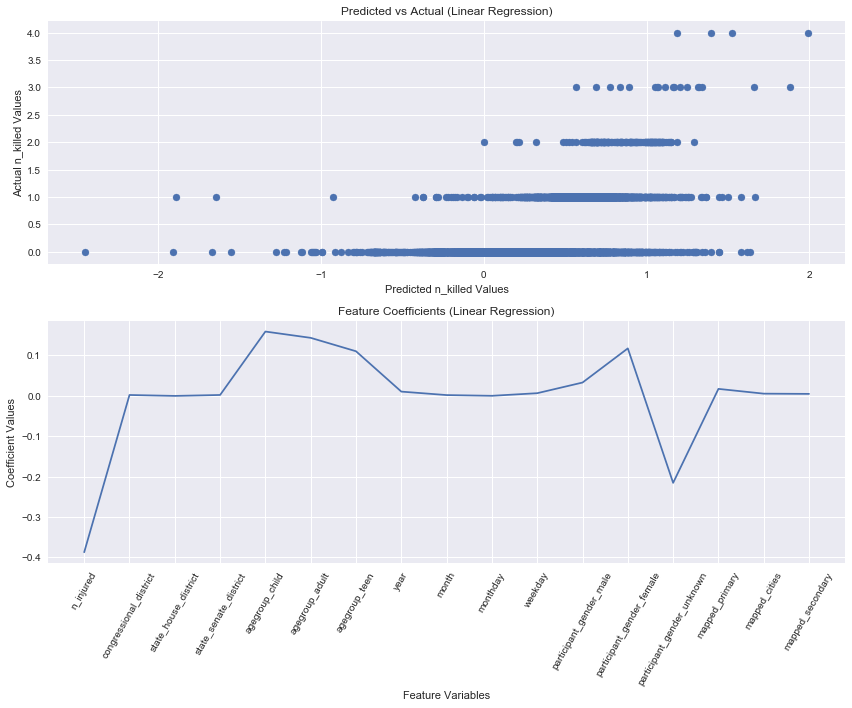

In [6]:
# Use a scatter plot to display the predicted vs actual values
sns.set()
fig = plt.figure(figsize = (12,10))
_ = plt.subplot(2,1,1)
_ = plt.scatter(y_pred,y_test)
_ = plt.xlabel('Predicted n_killed Values')
_ = plt.ylabel('Actual n_killed Values')
_ = plt.title('Predicted vs Actual (Linear Regression)')

# Plot the coefficients 
reg_coef = reg.coef_
_ = plt.subplot(2,1,2)
_ = plt.plot(range(len(X.columns)),reg_coef)
_ = plt.xticks(range(len(X.columns)),X,rotation=60)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Coefficient Values')
_ = plt.title('Feature Coefficients (Linear Regression)')
_ = plt.tight_layout()

Next, let's use the **Lasso** and **Ridge Regressors** on the data. For these classifiers, we will be specifying the hyperparameter alpha, which multiples the L1 term. In order to decide which alpha to use, we will be using GridSearchCV to iterate over a list of values for alpha. This will return the best alpha value and its "score".

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2)

# Define the parameter values that will be searched
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
# Create the parameter grid
param_grid = {'alpha':alphas}
# Instantiate the Lasso Regressor
lasso = Lasso()
# Instantiate the grid search
gscv = GridSearchCV(lasso, param_grid, scoring = 'r2', n_jobs = -1, cv = 10)
# Fit the training data into the model
gscv.fit(X_train, y_train)
    
# Print the best score and its respective parameters
print('The best score is:',gscv.best_score_)
print('The best parameters are:',gscv.best_params_)

The best score is: 0.39105275700175685
The best parameters are: {'alpha': 0.001}



R-squared: 0.3777536399756086
Root Mean Squared Error: 0.3911748359181883
Average 10-Fold CV Score: 0.370822586595191


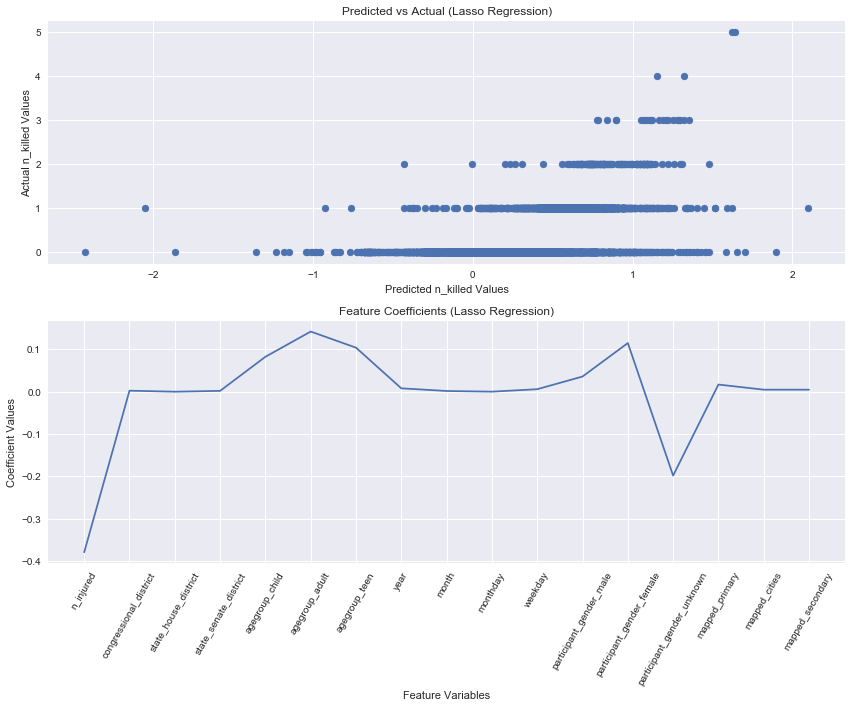

In [8]:
# Now use the best parameters to make predictions using the test data and compute the r-squared/RMSE
# (Note: The attribute .best_estimator_ returns the Lasso classifier with the optimal parameters)
best_lasso = gscv.best_estimator_
y_pred = best_lasso.predict(X_test)
print('\nR-squared: {}'.format(best_lasso.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))
cv_scores = cross_val_score(best_lasso,X,y,cv=10)
print("Average 10-Fold CV Score: {}".format(np.mean(cv_scores)))

fig = plt.figure(figsize = (12,10))
_ = plt.subplot(2,1,1)
_ = plt.scatter(y_pred,y_test)
_ = plt.xlabel('Predicted n_killed Values')
_ = plt.ylabel('Actual n_killed Values')
_ = plt.title('Predicted vs Actual (Lasso Regression)')
    
_ = plt.subplot(2,1,2)
lasso_coef = best_lasso.fit(X,y).coef_
_ = plt.plot(range(len(X.columns)),lasso_coef)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Coefficient Values')    
_ = plt.title('Feature Coefficients (Lasso Regression)')
_ = plt.xticks(range(len(X.columns)),X.columns,rotation=60)
_ = plt.tight_layout()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 3)

alphas = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {'alpha':alphas}
ridge = Ridge()
gscv = GridSearchCV(ridge, param_grid, scoring = 'r2', n_jobs = -1, cv = 10)
gscv.fit(X_train, y_train)
    
print('The best score is:',gscv.best_score_)
print('The best parameters are:',gscv.best_params_)

The best score is: 0.3988684407822701
The best parameters are: {'alpha': 10}



R-squared: 0.3585125826077893
Root Mean Squared Error: 0.3959605892336733
Average 10-Fold CV Score: 0.3711507665413988


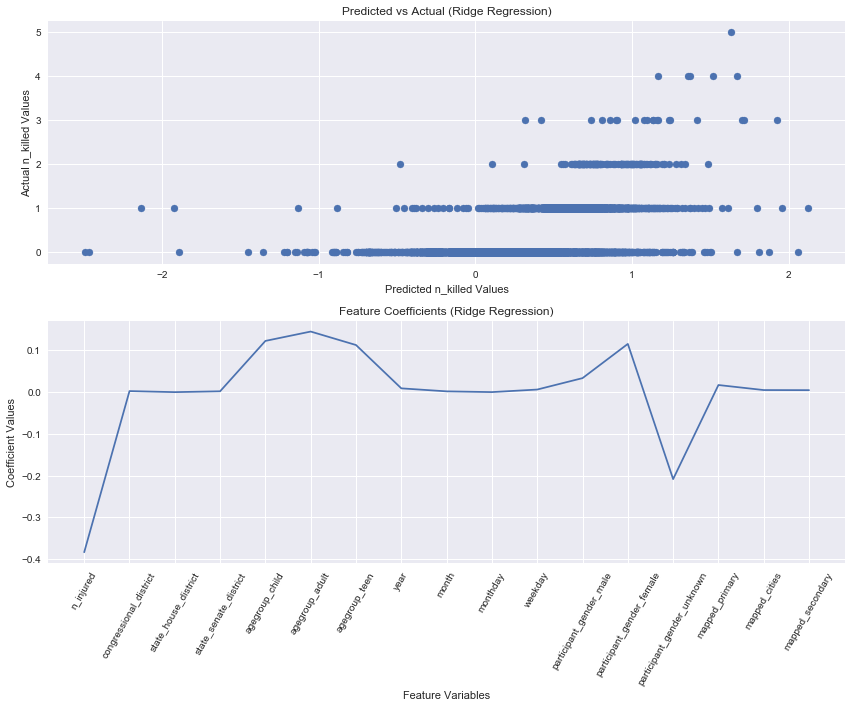

In [10]:
best_ridge = gscv.best_estimator_
y_pred = best_ridge.predict(X_test)
print('\nR-squared: {}'.format(best_ridge.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))
cv_scores = cross_val_score(best_ridge,X,y,cv=10)
print("Average 10-Fold CV Score: {}".format(np.mean(cv_scores)))

fig = plt.figure(figsize = (12,10))
_ = plt.subplot(2,1,1)
_ = plt.scatter(y_pred,y_test)
_ = plt.xlabel('Predicted n_killed Values')
_ = plt.ylabel('Actual n_killed Values')
_ = plt.title('Predicted vs Actual (Ridge Regression)')
    
_ = plt.subplot(2,1,2)
ridge_coef = best_ridge.fit(X,y).coef_
_ = plt.plot(range(len(X.columns)),ridge_coef)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Coefficient Values')    
_ = plt.title('Feature Coefficients (Ridge Regression)')
_ = plt.xticks(range(len(X.columns)),X.columns,rotation=60)
_ = plt.tight_layout()

- All 3 regression classifiers (Linear, Lasso, Ridge) had similar r-squared and RSME scores. Linear regression had the best r-squared score at 0.383 but it's still relatively a mediocre result. 
- When looking at the predicted vs actual plots, it's important to note that many of the predicted values were actually negative. This would imply that some incidents had a predicted NEGATIVE number of deaths which is impossible. 
- The feature coefficients plots show that n_injured and agegroup_adult have the biggest weight in the model while features such as congressional_district and month have low impact.

**3. Using the Decision Tree Regressor Classifier**

The next step is to seek the best hyperparameters for our models using **RandomizedSearchCV**, which is very similar to its cousin GridSearchCV except it instead randomly selects parameters to test. From there we can choose the best parameters that result in the best r-squared score. 

For our next classifer, we will use the **Decision Tree Regressor**, which predicts the response variable values by learning simple decision rules inferred from the feature data. RandomizedSearchCV is preferred over GridSearchCV in this scenario since there are going to be more parameter values to iterate over. Thus it will save computation time.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 4)

# Define the parameter values that will be randomly searched
max_depth = range(1,51)
min_samples_split = range(2,5)
min_samples_leaf = [1, 2]
# Create the parameter grid
param_grid = {'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}
# Instantiate the regressor
tree = DecisionTreeRegressor()
# Instantiate random search
rscv = RandomizedSearchCV(tree, param_grid, n_iter = 20, scoring = 'r2', n_jobs = -1, cv = 10, random_state = 5)
# Fit the training data into the model
rscv.fit(X_train, y_train)
    
# Print the best score and its respective parameters
print('The best score is:',rscv.best_score_)
print('The best parameters are:',rscv.best_params_)

The best score is: 0.8904454551677617
The best parameters are: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 5}



R-squared: 0.8994019760230402
Root Mean Squared Error: 0.1582681214695183
Average 10-Fold CV Score: 0.892788574164103


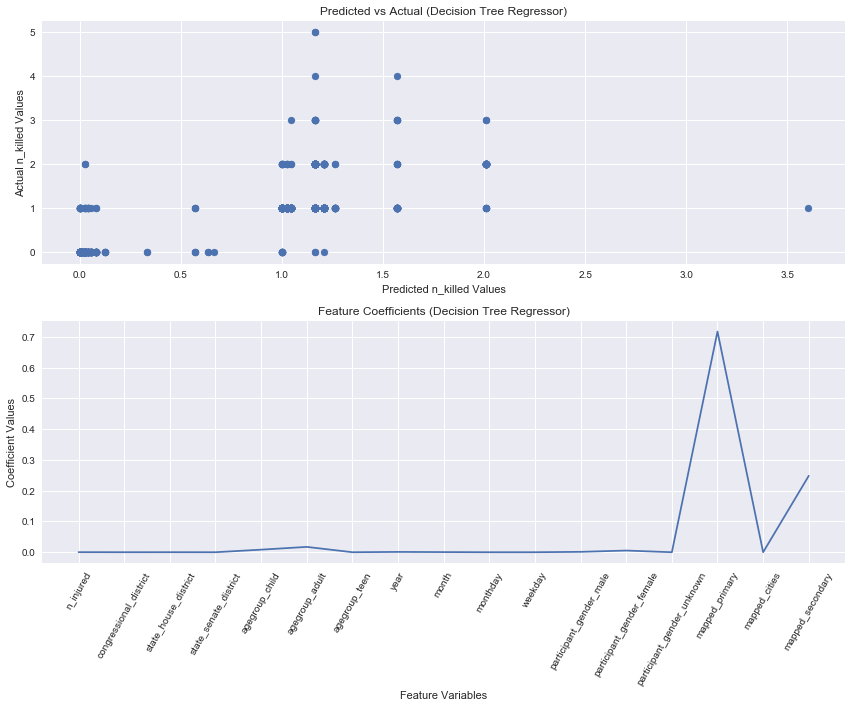

In [12]:
# Now use the best parameters to make predictions using the test data and compute the r-squared/RMSE
best_tree = rscv.best_estimator_
y_pred = best_tree.predict(X_test)
print('\nR-squared: {}'.format(best_tree.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))
cv_scores = cross_val_score(best_tree,X,y,cv=10)
print("Average 10-Fold CV Score: {}".format(np.mean(cv_scores)))
    
# Use a scatter plot to display the predicted vs actual values
fig = plt.figure(figsize = (12,10))
_ = plt.subplot(2,1,1)
_ = plt.scatter(y_pred,y_test)
_ = plt.xlabel('Predicted n_killed Values')
_ = plt.ylabel('Actual n_killed Values')
_ = plt.title('Predicted vs Actual (Decision Tree Regressor)')
    
# Plot the coefficients 
tree_coef = best_tree.feature_importances_
_ = plt.subplot(2,1,2)
_ = plt.plot(range(len(X.columns)),tree_coef)
_ = plt.xticks(range(len(X.columns)),X,rotation=60)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Coefficient Values')
_ = plt.title('Feature Coefficients (Decision Tree Regressor)')
_ = plt.tight_layout()

- The r-squared and RMSE scores have greatly improved using Decision Trees compared to the regression methods. The best results using the regressors was 0.38 r-squared and 0.4 RMSE using the Linear Regressor. Using the Decision Tree with RandomizedSearchCV, however, resulted in a 0.899 R-squared score and 0.158 RMSE. 
- For the predicted vs actual plot, there are no longer any negative values and there are fewer deviations (more space in between the points). 
- As for the feature coefficients plot, the decision tree put a significant amount of weight on the incident characteristics while putting very little weight elsewhere. This may be the main reason why there was such an enormous change in the r-squared/RMSE. 

**4. Using the Random Forest Ensemble Classifier**

Finally, let's use the **Random Forest** algorithm, which is an ensemble method which uses multiple decision trees. Each tree is built from a sample drawn with replacement (ex. a bootstrap sample) from the training set.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 6)
    
n_estimators = range(80,101)
max_depth = range(1,51)
min_samples_split = range(2,11)
min_samples_leaf = range(1,5)
bootstrap = [True, False]
param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap
    }
rf = RandomForestRegressor()
rscv = RandomizedSearchCV(rf, param_grid, n_iter = 20, scoring = 'r2', cv = 10, n_jobs = -1, random_state =7)
rscv.fit(X_train, y_train)
    
print('The best score is:',rscv.best_score_)
print('The best parameters are:',rscv.best_params_)

The best score is: 0.9060554116488531
The best parameters are: {'n_estimators': 89, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_depth': 26, 'bootstrap': True}



R-squared: 0.9026289308520125
Root Mean Squared Error: 0.15644826507612977
Average 10-Fold CV Score: 0.9039324037543788


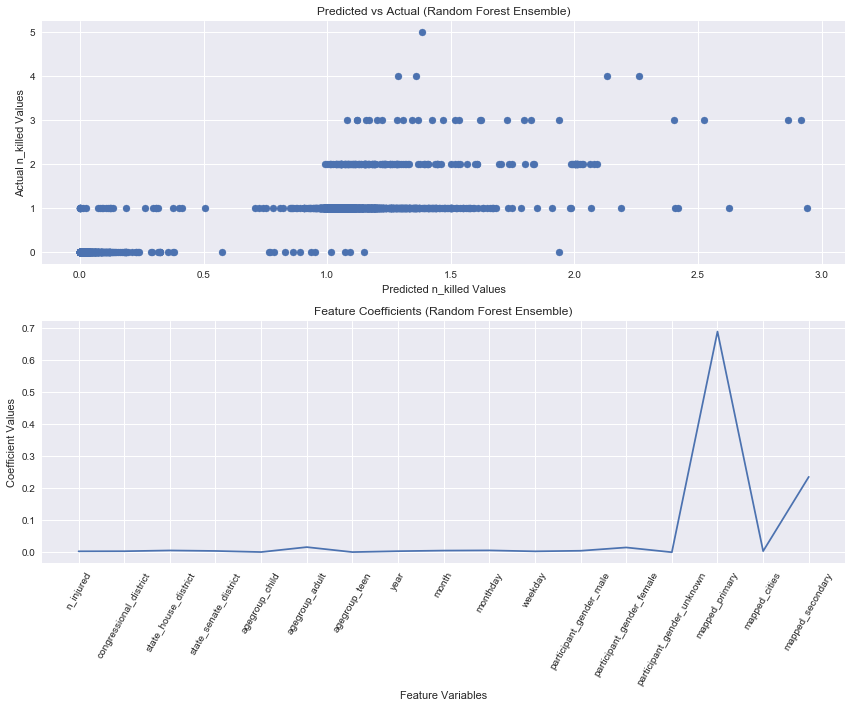

In [14]:
best_rf = rscv.best_estimator_
y_pred = best_rf.predict(X_test)
print('\nR-squared: {}'.format(best_rf.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))
cv_scores = cross_val_score(best_rf,X,y,cv=10)
print("Average 10-Fold CV Score: {}".format(np.mean(cv_scores)))
    
# Use a scatter plot to display the predicted vs actual values
fig = plt.figure(figsize = (12,10))
_ = plt.subplot(2,1,1)
_ = plt.scatter(y_pred,y_test)
_ = plt.xlabel('Predicted n_killed Values')
_ = plt.ylabel('Actual n_killed Values')
_ = plt.title('Predicted vs Actual (Random Forest Ensemble)')
    
# Plot the coefficients 
rf_coef = best_rf.feature_importances_
_ = plt.subplot(2,1,2)
_ = plt.plot(range(len(X.columns)),rf_coef)
_ = plt.xticks(range(len(X.columns)),X,rotation=60)
_ = plt.xlabel('Feature Variables')
_ = plt.ylabel('Coefficient Values')
_ = plt.title('Feature Coefficients (Random Forest Ensemble)')
_ = plt.tight_layout()

- Using random forest had slightly better r-squared and RMSE scores than using the decision tree model as it had 0.902 and 0.156, respectively. 
- Looking at the predicted vs actual plot, we can see that it has greater variance in the range of points. 
- When looking at the feature coefficients plot, it is nearly identical to that of the decision tree model. 